##### import libs

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from copy import deepcopy
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

from utils import load_data, evaluate, plot_feature_importances, train_test_split_wise

##### load data

In [2]:
user_item_data, user_meta_data, item_meta_data, test_pairs_data = load_data()

In [3]:
user_item_data_w_group_features = pd.read_parquet("data/user_item_data_w_group_features.parquet")
test_pairs_data_w_group_features = pd.read_parquet("data/test_pairs_data_w_group_features.parquet")

In [4]:
als_scores = np.load("dumps/ials_scores.npy")
test_als_scores = np.load("dumps/test_ials_scores.npy")

lightfm_scores = np.load("dumps/lightfm_scores.npy")
test_lightfm_scores = np.load("dumps/test_lightfm_scores.npy")

In [19]:
user_item_data_w_group_features["als_scores"] = als_scores.tolist()
test_pairs_data_w_group_features["als_scores"] = test_als_scores.tolist()

user_item_data_w_group_features["lightfm_scores"] = lightfm_scores.tolist()
test_pairs_data_w_group_features["lightfm_scores"] = test_lightfm_scores.tolist()

In [6]:
user_item_data_w_group_features.lightfm_scores = user_item_data_w_group_features.lightfm_scores.astype(np.float16)
test_pairs_data_w_group_features.lightfm_scores = test_pairs_data_w_group_features.lightfm_scores.astype(np.float16)

In [7]:
columns = list(set(user_item_data_w_group_features.columns.to_list()) - set([
    'bookmarks',
    'dislike',
    'explicit',
    'like',
    'share',
    'timespent',
]))

In [8]:
set(test_pairs_data_w_group_features.columns) == set(columns)

False

In [9]:
target = "like"

In [10]:
train_df, val_df = train_test_split(
    user_item_data_w_group_features[columns+[target]],
    test_size=0.15,
    random_state=42,
    shuffle=False,
)

In [11]:
train_df, val_df = train_test_split_wise(
    user_item_data_w_group_features[columns+[target]],
    test_size=0.15,
    random_state=42,
    shuffle=False,
)

In [12]:
def compute_lag(
        train_df,
        val_df,
        group_col,
        target_col,
        lag,
        ):
    train_df = train_df.copy()
    val_df = val_df.copy()
    grouped = train_df.groupby(group_col, as_index=False)
    lag_col_name = f"{target_col}_lag_{lag}"
    train_df[lag_col_name] = grouped[target_col].shift(lag).fillna(0).astype(np.int16)
    grouped = train_df.groupby(group_col, as_index=False)
    last_lag_by_user_id = grouped[lag_col_name].agg("last")
    val_df = val_df.merge(
        right=last_lag_by_user_id,
        on=group_col,
        how="left"
    )
    return train_df, val_df

In [13]:
train_df, val_df = compute_lag(
    train_df=train_df,
    val_df=val_df,
    group_col="user_id",
    target_col="like",
    lag=1
)

##### catboost

In [11]:
model = CatBoostClassifier(
    verbose=True,
    iterations=100,
    auto_class_weights="SqrtBalanced",
    # cat_features=["user_id", "source_id", "item_id"]
)

In [13]:
model.fit(train_df[-int(10e6):][columns],
          train_df[-int(10e6):][target])

Learning rate set to 0.5
0:	learn: 0.2902826	total: 669ms	remaining: 1m 6s
1:	learn: 0.2466375	total: 1.29s	remaining: 1m 3s
2:	learn: 0.2377287	total: 1.84s	remaining: 59.5s
3:	learn: 0.2331349	total: 2.46s	remaining: 59s
4:	learn: 0.2313798	total: 3.01s	remaining: 57.2s
5:	learn: 0.2287900	total: 3.67s	remaining: 57.5s
6:	learn: 0.2276790	total: 4.33s	remaining: 57.5s
7:	learn: 0.2267039	total: 4.94s	remaining: 56.9s
8:	learn: 0.2262440	total: 5.5s	remaining: 55.6s
9:	learn: 0.2258644	total: 6s	remaining: 54s
10:	learn: 0.2251140	total: 6.56s	remaining: 53.1s
11:	learn: 0.2239062	total: 7.17s	remaining: 52.6s
12:	learn: 0.2235472	total: 7.75s	remaining: 51.9s
13:	learn: 0.2233047	total: 8.39s	remaining: 51.6s
14:	learn: 0.2229934	total: 9.01s	remaining: 51s
15:	learn: 0.2226849	total: 9.68s	remaining: 50.8s
16:	learn: 0.2224724	total: 10.2s	remaining: 49.9s
17:	learn: 0.2220744	total: 10.8s	remaining: 49.2s
18:	learn: 0.2219042	total: 11.3s	remaining: 48.4s
19:	learn: 0.2215401	total

In [14]:
model.classes_

array([0, 1])

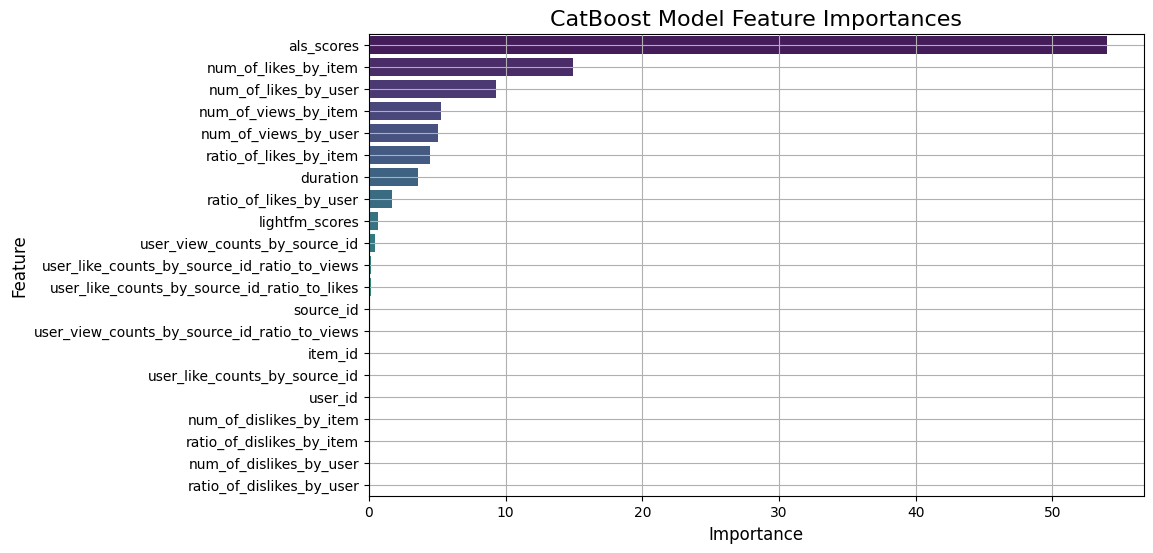

In [26]:
plot_feature_importances(model, graphic=True)

In [16]:
catboost_proba = model.predict_proba(val_df[columns])

In [17]:
evaluate(val_df.user_id.values,
         val_df[target].values,
         catboost_proba[:,1])

100%|██████████| 181721/181721 [00:49<00:00, 3649.03it/s]


0.7905575389502159

In [ ]:
evaluate(val_df.user_id.values,
         val_df[target].values,
         catboost_proba[:,1])

  0%|          | 0/49842 [00:00<?, ?it/s]

100%|██████████| 49842/49842 [00:04<00:00, 10402.08it/s]


0.6286449019964592

In [ ]:
evaluate(val_df.user_id.values,
         val_df[target].values,
         catboost_proba[:,1])

100%|██████████| 181721/181721 [00:49<00:00, 3672.56it/s]


0.6468600584223315

### submission

In [12]:
train_df, val_df = compute_lag(
    train_df=user_item_data_w_group_features,
    val_df=test_pairs_data_w_group_features,
    group_col="user_id",
    target_col="like",
    lag=1
)

In [22]:
model = CatBoostClassifier(
    verbose=False,
    iterations=100,
    auto_class_weights="SqrtBalanced",
    # cat_features=["user_id", "source_id", "item_id"]
)

In [23]:
model.fit(user_item_data_w_group_features[-int(10e6):][columns],
          user_item_data_w_group_features[-int(10e6):][target])

In [ ]:
model.fit(train_df[-int(10e6):][columns+["like_lag_1"]],
          train_df[-int(10e6):][target])

In [20]:
test_proba = model.predict_proba(val_df[columns+["like_lag_1"]])

In [24]:
test_proba = model.predict_proba(test_pairs_data_w_group_features[columns])

In [25]:
test_pairs_data["predict"] = test_proba[:,1]
test_pairs_data.to_csv("./cbc_group_fs_lfm_als_submission.csv", index=False)